
**[Coffee Bean Dataset](https://www.kaggle.com/datasets/gpiosenka/coffee-bean-dataset-resized-224-x-224?select=train)**

In [1]:
import time
import numpy as np
import os
from glob import glob
import pydot
from typing import List, Tuple
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image
import pathlib
import shutil
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model

from tensorflow.python.keras.utils import layer_utils
#from tensorflow.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.imagenet_utils import preprocess_input


In [2]:
train_dir = os.path.join( 'Coffee Bean Dataset/train')
test_dir = os.path.join('Coffee Bean Dataset/test')

In [3]:
df=pd.read_csv("Coffee Bean Dataset/Coffee Bean.csv")

In [4]:
df.head()

,class index,filepaths,labels,data set
0,0,train/Dark/dark (1).png,Dark,train
1,0,train/Dark/dark (10).png,Dark,train
2,0,train/Dark/dark (100).png,Dark,train
3,0,train/Dark/dark (101).png,Dark,train
4,0,train/Dark/dark (102).png,Dark,train


In [5]:
df.labels.value_counts()

Dark      400
Green     400
Light     400
Medium    400
Name: labels, dtype: int64

In [6]:
df["data set"].value_counts()

train    1200
test      400
Name: data set, dtype: int64

**Data pre-processing and data augmentation**

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class. This class allows you to:

- configure random transformations and normalization operations to be done on your image data during training
- instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.

In [7]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

These are just a few of the options available :-

- **rotation_range** is a value in degrees (0-180), a range within which to randomly rotate pictures
- **width_shift** and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- **rescale** is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
- **shear_range** is for randomly applying shearing transformations
- **zoom_range** is for randomly zooming inside pictures
- **horizontal_flip** is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
- **fill_mode** is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.



In [8]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 1200 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [9]:
folders = glob('Coffee Bean Dataset/train/*')
folders

['Coffee Bean Dataset/train\\Dark',
 'Coffee Bean Dataset/train\\Green',
 'Coffee Bean Dataset/train\\Light',
 'Coffee Bean Dataset/train\\Medium']

## Model creation 

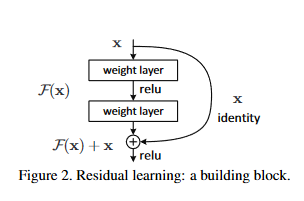

## ResNet building blocks

In the previous section I talked about the identity block. The one above skipped over two convolution layers. A more powerful version of the residual block is one that skips over three convolutional layers. In this notebook I will implement the latter.

I will also use a batch normalization layer after each convolutional layer, which helps by speeding up the training. If you want to read more about this, check out this article on Machine Learning Mastery.

The identity block is used when the input x has the same dimension (width and height) as the output of the third layer. When this condition is not met, we use a convolution block.

The only difference between the identity block and the convolution block is that the second has another convolution layer (plus a batch normalization) on the skip conection path. The convolution layer on the skip connection path has the purpose of resizing x so that its dimension matches the output and thus we would be able to add those two together.


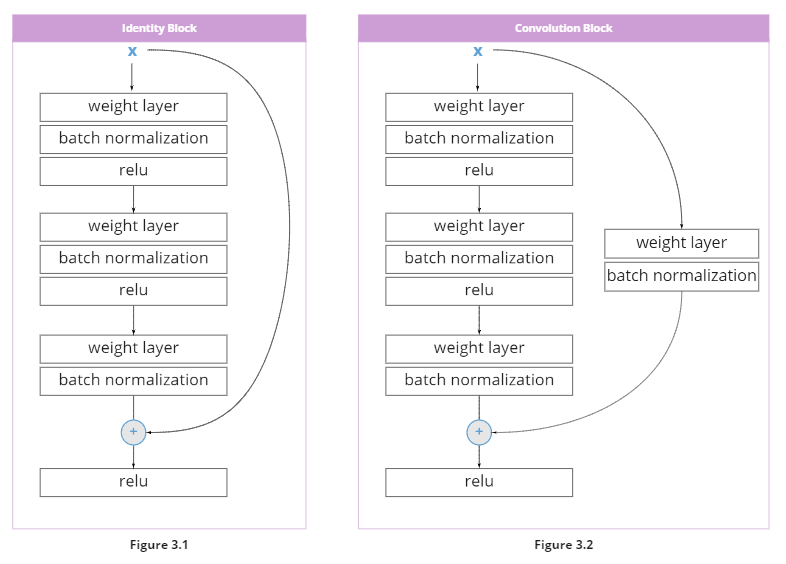

[Code source](https://www.kaggle.com/code/mishki/resnet-keras-code-from-scratch-train-on-gpu) customized ResNet50

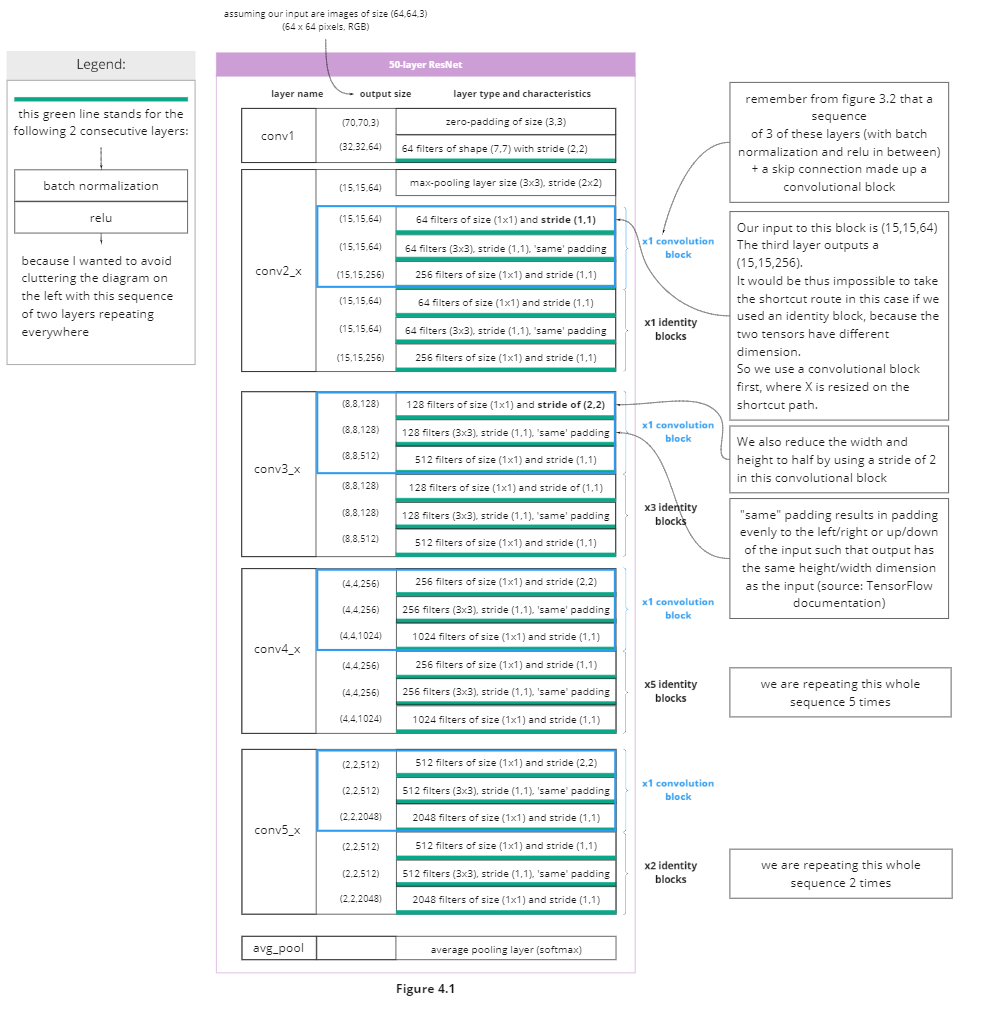

In [10]:
def identity_block(X: tf.Tensor, level: int, block: int, filters: List[int]) -> tf.Tensor:
    """
    Creates an identity block (see figure 3.1 from readme)

    Input:
        X - input tensor of shape (m, height_prev, width_prev, chan_prev)
        level - integer, one of the 5 levels that our networks is conceptually divided into (see figure 3.1 in the readme file)
              - level names have the form: conv2_x, conv3_x ... conv5_x
        block - each conceptual level has multiple blocks (1 identity and several convolutional blocks)
                block is the number of this block within its conceptual layer
                i.e. first block from level 2 will be named conv2_1
        filters - a list on integers, each of them defining the number of filters in each convolutional layer

    Output:
        X - tensor (m, height, width, chan)
    """

    # layers will be called conv{level}_iden{block}_{convlayer_number_within_block}'
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters

    # the shortcut branch of the identity block
    # takes the value of the block input
    X_shortcut = X

    # first convolutional layer (plus batch norm & relu activation, of course)
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)

    # second convolutional layer
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1),
               padding='same', name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = Activation('relu')(X)

    # third convolutional layer
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)

    # add shortcut branch to main path
    X = Add()([X, X_shortcut])

    # relu activation at the end of the block
    X = Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)

    return X

In [11]:
def convolutional_block(X: tf.Tensor, level: int, block: int, filters: List[int], s: Tuple[int,int,int]=(2, 2)) -> tf.Tensor:
    """
    Creates a convolutional block (see figure 3.1 from readme)

    Input:
        X - input tensor of shape (m, height_prev, width_prev, chan_prev)
        level - integer, one of the 5 levels that our networks is conceptually divided into (see figure 3.1 in the readme file)
              - level names have the form: conv2_x, conv3_x ... conv5_x
        block - each conceptual level has multiple blocks (1 identity and several convolutional blocks)
                block is the number of this block within its conceptual layer
                i.e. first block from level 2 will be named conv2_1
        filters - a list on integers, each of them defining the number of filters in each convolutional layer
        s   - stride of the first layer;
            - a conv layer with a filter that has a stride of 2 will reduce the width and height of its input by half

    Output:
        X - tensor (m, height, width, chan)
    """

    # layers will be called conv{level}_{block}_{convlayer_number_within_block}'
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters

    # the shortcut branch of the convolutional block
    X_shortcut = X

    # first convolutional layer
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=s, padding='valid',
               name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)

    # second convolutional layer
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1), padding='same',
               name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=2, type='relu'))(X)

    # third convolutional layer
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)

    # shortcut path
    X_shortcut = Conv2D(filters=f3, kernel_size=(1, 1), strides=s, padding='valid',
                        name=conv_name.format(layer='short', type='conv'),
                        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=conv_name.format(layer='short', type='bn'))(X_shortcut)

    # add shortcut branch to main path
    X = Add()([X, X_shortcut])

    # nonlinearity
    X = Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)

    return X

In [12]:
def ResNet50(input_size: Tuple[int,int,int], classes: int) -> Model:
    """
        Builds the ResNet50 model (see figure 4.2 from readme)

        Input:
            - input_size - a (height, width, chan) tuple, the shape of the input images
            - classes - number of classes the model must learn

        Output:
            model - a Keras Model() instance
    """

    # tensor placeholder for the model's input
    X_input = Input(input_size)

    ### Level 1 ###

    # padding
    X = ZeroPadding2D((3, 3))(X_input)

    # convolutional layer, followed by batch normalization and relu activation
    X = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2),
               name='conv1_1_1_conv',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='conv1_1_1_nb')(X)
    X = Activation('relu')(X)

    ### Level 2 ###

    # max pooling layer to halve the size coming from the previous layer
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # 1x convolutional block
    X = convolutional_block(X, level=2, block=1, filters=[64, 64, 256], s=(1, 1))

    # 2x identity blocks
    X = identity_block(X, level=2, block=2, filters=[64, 64, 256])
    X = identity_block(X, level=2, block=3, filters=[64, 64, 256])

    ### Level 3 ###

    # 1x convolutional block
    X = convolutional_block(X, level=3, block=1, filters=[128, 128, 512], s=(2, 2))

    # 3x identity blocks
    X = identity_block(X, level=3, block=2, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=3, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=4, filters=[128, 128, 512])

    ### Level 4 ###
    # 1x convolutional block
    X = convolutional_block(X, level=4, block=1, filters=[256, 256, 1024], s=(2, 2))
    # 5x identity blocks
    X = identity_block(X, level=4, block=2, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=3, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=4, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=5, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=6, filters=[256, 256, 1024])

    ### Level 5 ###
    # 1x convolutional block
    X = convolutional_block(X, level=5, block=1, filters=[512, 512, 2048], s=(2, 2))
    # 2x identity blocks
    X = identity_block(X, level=5, block=2, filters=[512, 512, 2048])
    X = identity_block(X, level=5, block=3, filters=[512, 512, 2048])

    # Pooling layers
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc_' + str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [13]:
# set input image parameters
image_size = (224, 224) 
channels = 3
num_classes = 4

In [14]:
model = ResNet50(input_size = (image_size[1], image_size[0], channels), classes = num_classes)

In [15]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1_1_1_conv (Conv2D)        (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

                                                                                                  
 activation_2 (Activation)      (None, 55, 55, 64)   0           ['conv2_3_2_bn[0][0]']           
                                                                                                  
 conv2_3_3_conv (Conv2D)        (None, 55, 55, 256)  16640       ['activation_2[0][0]']           
                                                                                                  
 conv2_3_3_bn (BatchNormalizati  (None, 55, 55, 256)  1024       ['conv2_3_3_conv[0][0]']         
 on)                                                                                              
                                                                                                  
 add_2 (Add)                    (None, 55, 55, 256)  0           ['conv2_3_3_bn[0][0]',           
                                                                  'conv2_2_3_relu[0][0]']         
          

 on)                                                                                              
                                                                                                  
 add_5 (Add)                    (None, 28, 28, 512)  0           ['conv3_3_3_bn[0][0]',           
                                                                  'conv3_2_3_relu[0][0]']         
                                                                                                  
 conv3_3_3_relu (Activation)    (None, 28, 28, 512)  0           ['add_5[0][0]']                  
                                                                                                  
 conv3_4_1_conv (Conv2D)        (None, 28, 28, 128)  65664       ['conv3_3_3_relu[0][0]']         
                                                                                                  
 conv3_4_1_bn (BatchNormalizati  (None, 28, 28, 128)  512        ['conv3_4_1_conv[0][0]']         
 on)      

 add_8 (Add)                    (None, 14, 14, 1024  0           ['conv4_2_3_bn[0][0]',           
                                )                                 'conv4_1_3_relu[0][0]']         
                                                                                                  
 conv4_2_3_relu (Activation)    (None, 14, 14, 1024  0           ['add_8[0][0]']                  
                                )                                                                 
                                                                                                  
 conv4_3_1_conv (Conv2D)        (None, 14, 14, 256)  262400      ['conv4_2_3_relu[0][0]']         
                                                                                                  
 conv4_3_1_bn (BatchNormalizati  (None, 14, 14, 256)  1024       ['conv4_3_1_conv[0][0]']         
 on)                                                                                              
          

                                                                                                  
 conv4_6_1_conv (Conv2D)        (None, 14, 14, 256)  262400      ['conv4_5_3_relu[0][0]']         
                                                                                                  
 conv4_6_1_bn (BatchNormalizati  (None, 14, 14, 256)  1024       ['conv4_6_1_conv[0][0]']         
 on)                                                                                              
                                                                                                  
 conv4_6_1_relu (Activation)    (None, 14, 14, 256)  0           ['conv4_6_1_bn[0][0]']           
                                                                                                  
 conv4_6_2_conv (Conv2D)        (None, 14, 14, 256)  590080      ['conv4_6_1_relu[0][0]']         
                                                                                                  
 conv4_6_2

 on)                                                                                              
                                                                                                  
 conv5_3_1_relu (Activation)    (None, 7, 7, 512)    0           ['conv5_3_1_bn[0][0]']           
                                                                                                  
 conv5_3_2_conv (Conv2D)        (None, 7, 7, 512)    2359808     ['conv5_3_1_relu[0][0]']         
                                                                                                  
 conv5_3_2_bn (BatchNormalizati  (None, 7, 7, 512)   2048        ['conv5_3_2_conv[0][0]']         
 on)                                                                                              
                                                                                                  
 activation_12 (Activation)     (None, 7, 7, 512)    0           ['conv5_3_2_bn[0][0]']           
          

In [16]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']    
)

In [17]:
# fit the model
epochs = 50
history = model.fit(training_set, validation_data=test_set,epochs=epochs,
            steps_per_epoch=len(training_set),
            validation_steps=len(test_set), 
            verbose=1,)

Epoch 1/50
75/75 [==============================] - 44s 497ms/step - loss: 3.6203 - accuracy: 0.4858 - val_loss: 3.7405 - val_accuracy: 0.2500
Epoch 2/50
75/75 [==============================] - 37s 484ms/step - loss: 2.0802 - accuracy: 0.6333 - val_loss: 7.0189 - val_accuracy: 0.2500
Epoch 3/50
75/75 [==============================] - 37s 487ms/step - loss: 1.1414 - accuracy: 0.7775 - val_loss: 7.2100 - val_accuracy: 0.2500
Epoch 4/50
75/75 [==============================] - 37s 486ms/step - loss: 0.6865 - accuracy: 0.8558 - val_loss: 5.9700 - val_accuracy: 0.2500
Epoch 5/50
75/75 [==============================] - 37s 486ms/step - loss: 0.6008 - accuracy: 0.8667 - val_loss: 0.9948 - val_accuracy: 0.7675
Epoch 6/50
75/75 [==============================] - 37s 488ms/step - loss: 0.7307 - accuracy: 0.8592 - val_loss: 4.4488 - val_accuracy: 0.4225
Epoch 7/50
75/75 [==============================] - 37s 487ms/step - loss: 0.6949 - accuracy: 0.8758 - val_loss: 0.2917 - val_accuracy: 0.9075

In [18]:
scores = model.evaluate(test_set)

25/25 [==============================] - 3s 132ms/step - loss: 0.0257 - accuracy: 0.9850


In [19]:
print("test loss",scores[0])
print("test accuracy",scores[1])

test loss 0.025668203830718994
test accuracy 0.9850000143051147


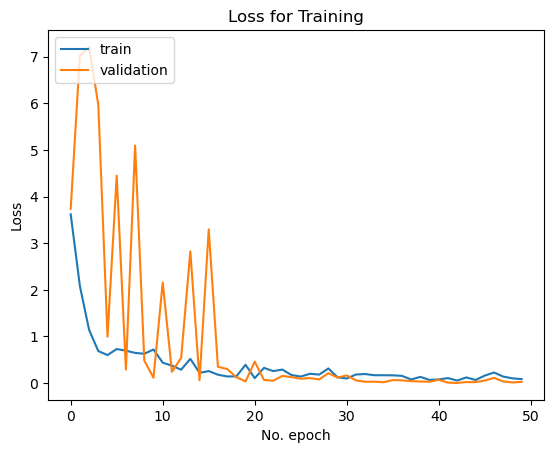

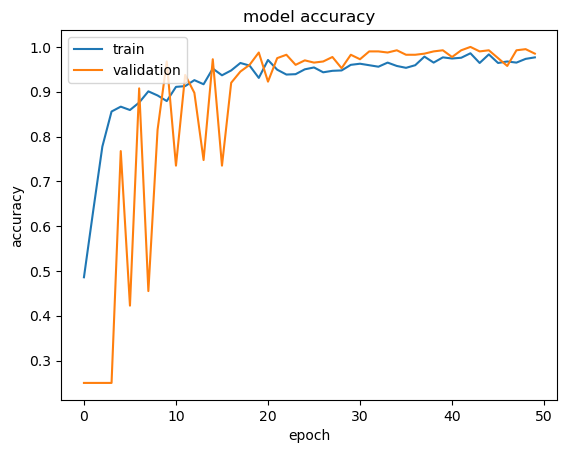

In [20]:
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Training')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(['train', 'validation'], loc="upper left")
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()